In [2]:
import pandas as pd
import geopandas as gpd
import os
from src.plot_map import plot_map
import warnings

warnings.filterwarnings('ignore')



In [3]:
# Step 1: Read and anonymize the data
# If the path exists, read the data from the excel file
# This only happens on my machine, as the non-anonymized data is not included in the repository
if os.path.exists("data/file1.xlsx"):
    df = pd.read_excel("data/file1.xlsx", sheet_name="Daten Tabelle")
    # Sort the farms alphabetically, give them Farm 1, Farm 2, etc. names
    # Remove nan values from the Betrieb column
    df = df.dropna(subset=["Betrieb"])
    df = df.sort_values(by="Betrieb")
    farm_dict = {farm: f"Farm {i+1}" for i, farm in enumerate(df["Betrieb"].unique())}
    df["Betrieb"] = df["Betrieb"].map(farm_dict)

    # Do the same with the fields
    df = df.dropna(subset=["Feldname"])
    df["Feldname"] = df["Feldname"].astype(str)
    # Ensure that the field names are unique in the dataset by appending the farm name to the field name
    df["Feldname"] = df.apply(lambda x: f"{x['Betrieb']}_{x['Feldname']}", axis=1)
    df = df.sort_values(by="Feldname")
    field_dict = {
        field: f"Field {i+1}" for i, field in enumerate(df["Feldname"].unique())
    }
    df["Feldname"] = df["Feldname"].map(field_dict)

    # Remove the Shp column as it may contain sensitive information
    df = df.drop(columns=["Shp"])

    # export it as a csv file
    df.to_csv("data/file1.csv", index=False)

# Read the anonymized data
df = pd.read_csv("data/file1.csv")

In [4]:
# Process the dataframe
df = df.drop(columns=["Unnamed: 11", "Unnamed: 12"])
df.rename(
    columns={
        "ID": "id",
        "Betrieb": "farm",
        "Feldname": "field_name",
        "Fläche (ha)": "area_ha",
        "Erntejahr": "harvest_year",
        "Aussaattermin": "sowing_date",
        "Erntedatum": "harvest_date",
        "Kultur": "crop",
        "realer Ertrag (dt / ha)": "real_yield_dt_ha",
        "reale N-Menge (kg N / ha)": "real_n_amount_kg_n_ha",
    },
    inplace=True,
)
df["crop"].replace({"Winterweichweizen": "winter_wheat"}, inplace=True)

print(df["farm"].unique())

['Farm 10' 'Farm 11' 'Farm 12' 'Farm 13' 'Farm 14' 'Farm 15' 'Farm 16'
 'Farm 1' 'Farm 2' 'Farm 3' 'Farm 4' 'Farm 5' 'Farm 6' 'Farm 7' 'Farm 8'
 'Farm 9']


In [5]:
# Remove the nan values
farms = [farm for farm in df["farm"].unique() if farm == farm]

In [6]:
# Filter the rows that do not have winter wheat in the culture column
df = df[df["crop"] == "winter_wheat"]

#Print the number of rows left
print(df.shape)


(396, 10)


## Data Analysis Summary

We are left with **396 data points** to analyze.

### DataFrame Overview

- **Total Entries:** 396
- **Columns:** 11

| Column                 | Non-Null Count | Dtype           |
|------------------------|----------------|-----------------|
| id                     | 0              | float64         |
| farm                   | 396            | object          |
| field_name             | 396            | object          |
| area_ha                | 396            | float64         |
| shp                    | 194            | object          |
| harvest_year           | 396            | float64         |
| sowing_date            | 321            | object          |
| harvest_date           | 350            | datetime64[ns]  |
| crop                   | 396            | object          |
| real_yield_dt_ha       | 396            | float64         |
| real_n_amount_kg_n_ha  | 396            | float64         |

### Unique Farms

The dataset includes data from the following farms:



<Axes: title={'center': 'Yield vs Nitrogen amount'}, xlabel='real_n_amount_kg_n_ha', ylabel='real_yield_dt_ha'>

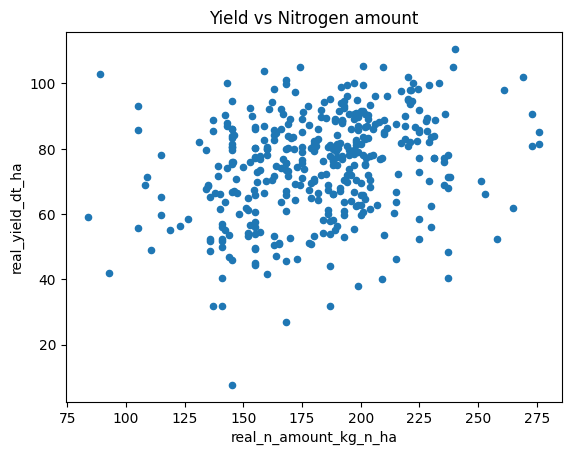

In [7]:
# Let's plot a graph with the yield and the nitrogen amount per hectare
df["real_yield_dt_ha"] = df["real_yield_dt_ha"].astype(float)
df["real_n_amount_kg_n_ha"] = df["real_n_amount_kg_n_ha"].astype(float)

# Use the farm as color
df.plot.scatter(y="real_yield_dt_ha", x="real_n_amount_kg_n_ha", title="Yield vs Nitrogen amount")

0.07696352334394863


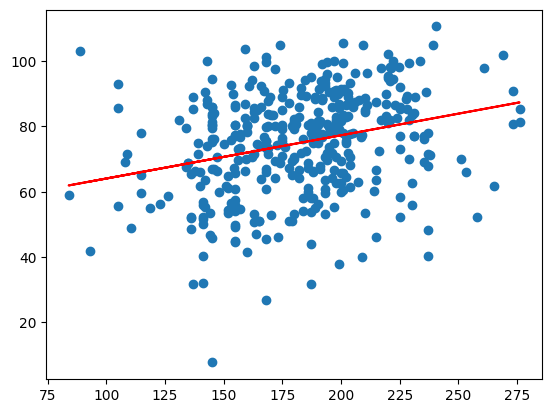

In [8]:
# Apply a linear regression
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

X = df["real_n_amount_kg_n_ha"].values.reshape(-1, 1)
y = df["real_yield_dt_ha"].values.reshape(-1, 1)


reg = LinearRegression().fit(X, y)
print(reg.score(X, y))

plt.scatter(X, y)
plt.plot(X, reg.predict(X), color="red")
plt.show()

### Interpretation of Linear Regression Score

The `reg.score(X, y)` method returns the coefficient of determination \( R^2 \) of the prediction. In this case, the \( R^2 \) value is **0.07**.

#### What does an \( R^2 \) value of 0.07 mean?

- **Explanation of Variance**: An \( R^2 \) value of 0.07 indicates that only 7% of the variance in the dependent variable (real nitrogen amount per hectare) can be explained by the independent variable (real yield per hectare). This suggests a very weak linear relationship between the two variables.
- **Model Performance**: The low \( R^2 \) value implies that the linear regression model does not fit the data well. Most of the variability in the nitrogen amount per hectare is not captured by the yield per hectare.
- **Implications**: This result suggests that other factors not included in the model may have a significant impact on the nitrogen amount per hectare. It may be beneficial to explore additional variables or use more complex models to better understand and predict the nitrogen amount.

In summary, the linear regression model with an \( R^2 \) value of 0.07 indicates a poor fit, suggesting that the yield per hectare is not a strong predictor of the nitrogen amount per hectare in this dataset.

<Axes: xlabel='real_n_amount_kg_n_ha', ylabel='real_yield_dt_ha'>

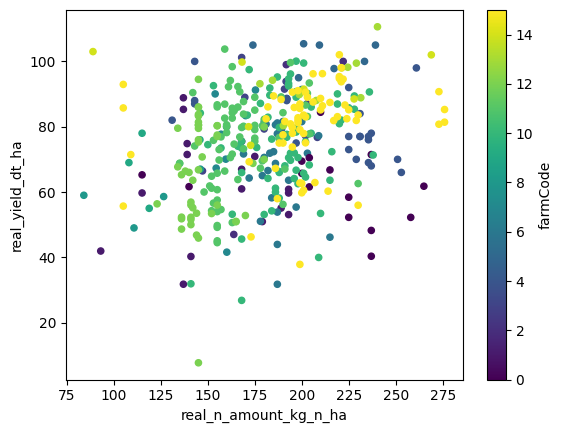

In [9]:
# Let's add the farm in the plot
df["farm"] = df["farm"].astype("category")
df["farmCode"] = df["farm"].cat.codes
df.plot.scatter(y="real_yield_dt_ha", x="real_n_amount_kg_n_ha", c="farmCode", colormap="viridis")


0.3875


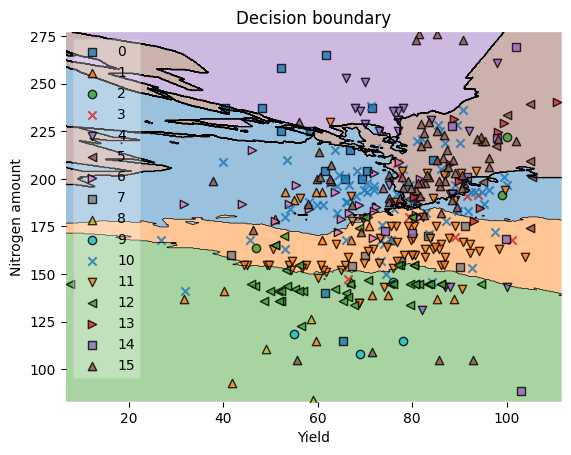

In [22]:
# Let's train a KNN model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df[["real_yield_dt_ha", "real_n_amount_kg_n_ha"]]
y = df["farmCode"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=33)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print(accuracy_score(y_test, y_pred))

# Let's plot the decision boundary
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X.values, y.values, clf=knn, legend=2)
plt.xlabel("Yield")
plt.ylabel("Nitrogen amount")
plt.title("Decision boundary")
plt.show()


Naive Bayes Accuracy: 0.25


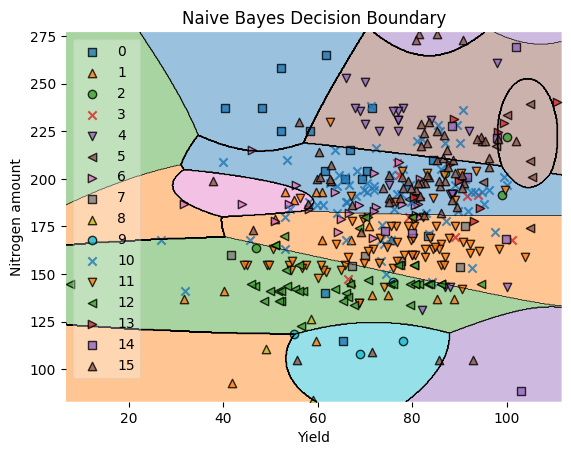

In [23]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Define the Gaussian Naive Bayes model
gnb = GaussianNB()

# Fit the model to the training data
gnb.fit(X_train, y_train)

# Predict the labels for the test set
y_pred_nb = gnb.predict(X_test)

# Calculate the accuracy of the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb}")

# Plot the decision boundary
plot_decision_regions(X.values, y.values, clf=gnb, legend=2)
plt.xlabel("Yield")
plt.ylabel("Nitrogen amount")
plt.title("Naive Bayes Decision Boundary")
plt.show()

Mean Absolute Error: 12.259253927243849


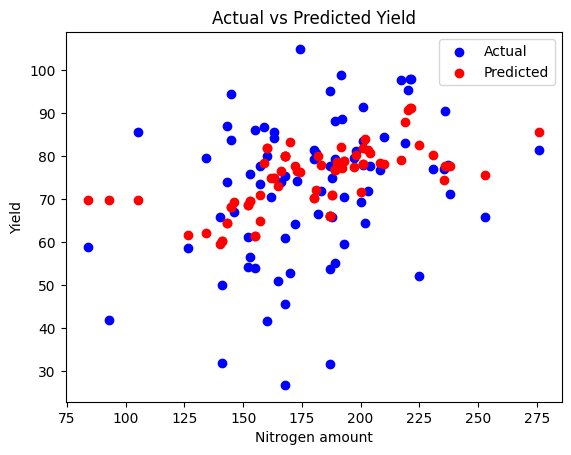

In [11]:
# This really does not tell us much, let's try to use the yield as target
X = df[["real_n_amount_kg_n_ha"]]
y = df["real_yield_dt_ha"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Let's plot the predictions vs actual values
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.xlabel("Nitrogen amount")
plt.ylabel("Yield")
plt.title("Actual vs Predicted Yield")
plt.legend()
plt.show()


Cluster Centers:
 [[191.73181006]
 [148.73843333]
 [232.15970149]]


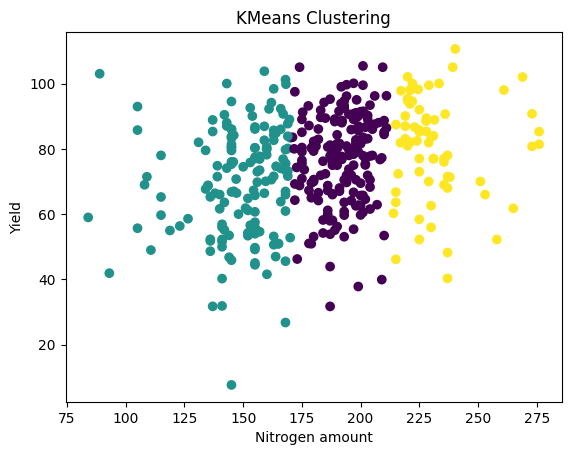

In [12]:
from sklearn.cluster import KMeans

# Define the number of clusters
n_clusters = 3

# Initialize the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(X)

# Add the cluster labels to the dataframe
df['cluster'] = kmeans.labels_

# Print the cluster centers
print("Cluster Centers:\n", kmeans.cluster_centers_)

# Plot the clusters
plt.scatter(df['real_n_amount_kg_n_ha'], df['real_yield_dt_ha'], c=df['cluster'], cmap='viridis')
plt.xlabel("Nitrogen amount")
plt.ylabel("Yield")
plt.title("KMeans Clustering")
plt.show()

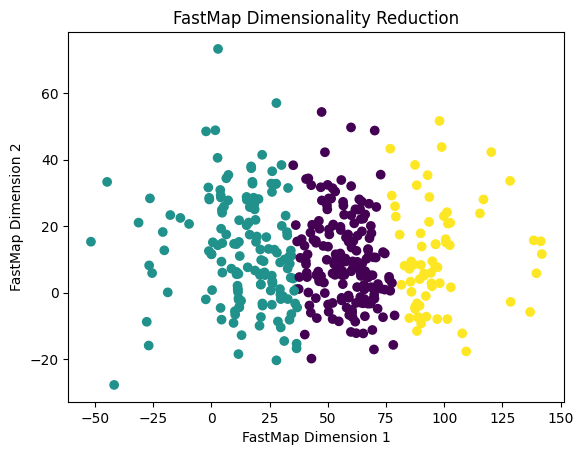

In [13]:
import numpy as np


def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


def choose_distant_objects(X):
    idx1 = np.random.randint(0, len(X))
    idx2 = np.argmax([euclidean_distance(X[idx1], X[i]) for i in range(len(X))])
    return idx1, idx2


def fastmap(X, k):
    n = len(X)
    Y = np.zeros((n, k))

    for j in range(k):
        idx1, idx2 = choose_distant_objects(X)
        a, b = X[idx1], X[idx2]
        d_ab = euclidean_distance(a, b)

        if d_ab == 0:
            continue

        for i in range(n):
            xi = X[i]
            d_ai = euclidean_distance(a, xi)
            d_bi = euclidean_distance(b, xi)
            Y[i, j] = (d_ai**2 + d_ab**2 - d_bi**2) / (2 * d_ab)

        X = np.array([xi - (Y[i, j] * (b - a) / d_ab) for i, xi in enumerate(X)])

    return Y


# Add the vegetation time to the dataframe
df["vegetation_time"] = (
    pd.to_datetime(df["harvest_date"]) - pd.to_datetime(df["sowing_date"])
).dt

# Prepare the data
X = df[["real_n_amount_kg_n_ha", "real_yield_dt_ha"]].values

# Apply FastMap to reduce to 2 dimensions
Y = fastmap(X, 2)

# Plot the reduced data
plt.scatter(Y[:, 0], Y[:, 1], c=df["cluster"], cmap="viridis")
plt.xlabel("FastMap Dimension 1")
plt.ylabel("FastMap Dimension 2")
plt.title("FastMap Dimensionality Reduction")
plt.show()

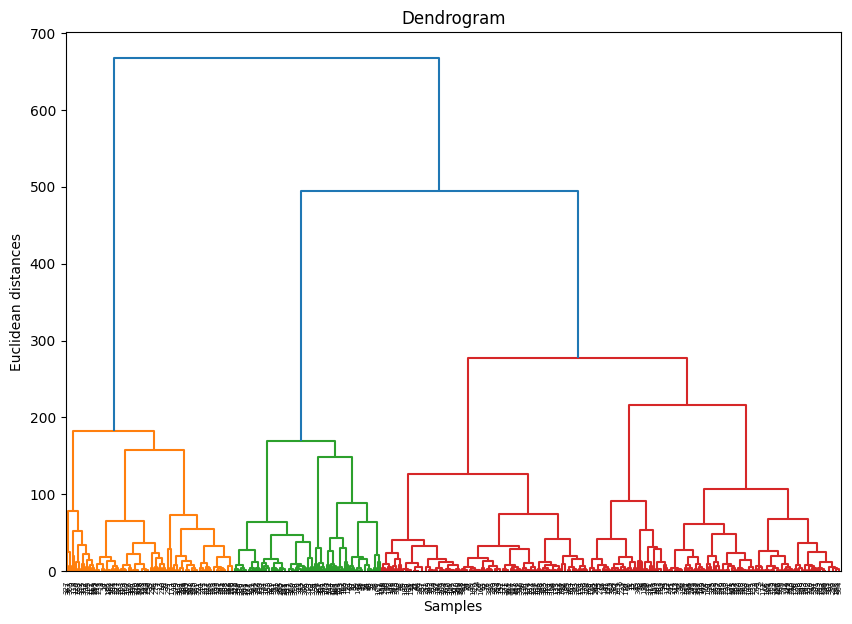

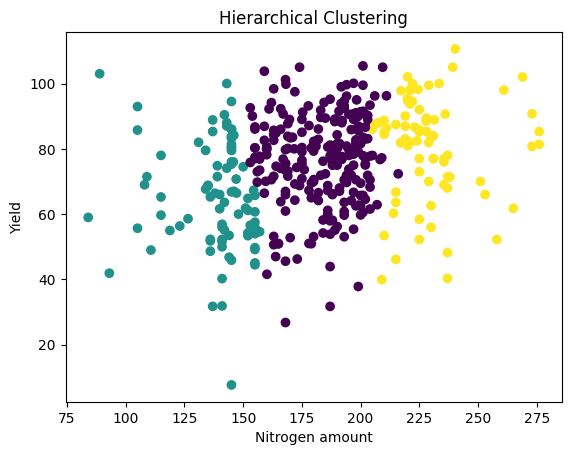

In [14]:
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

# Perform hierarchical clustering
hc = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
y_hc = hc.fit_predict(X)

# Add the hierarchical cluster labels to the dataframe
df['hc_cluster'] = y_hc

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.title("Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Euclidean distances")
plt.show()

# Plot the clusters
plt.scatter(df['real_n_amount_kg_n_ha'], df['real_yield_dt_ha'], c=df['hc_cluster'], cmap='viridis')
plt.xlabel("Nitrogen amount")
plt.ylabel("Yield")
plt.title("Hierarchical Clustering")
plt.show()

Birch

BIRCH Cluster Centers:
 [[137.          31.76223776]
 [168.          60.95111751]
 [179.          50.93701856]
 [141.          40.25714286]
 [163.82        47.        ]
 [160.11        41.58      ]
 [140.          61.63869705]
 [163.          53.1823271 ]
 [141.          31.89243249]
 [155.          53.99396538]
 [151.          61.85485152]
 [155.          44.76986544]
 [163.          50.64094396]
 [152.          61.16363822]
 [152.          53.83461538]
 [148.          60.        ]
 [155.          49.45432615]
 [155.          60.70971787]
 [157.          54.63041034]
 [155.          57.53093311]
 [153.          56.60215054]
 [166.          63.82258065]
 [141.          51.93      ]
 [144.          53.5       ]
 [142.          55.17      ]
 [144.          46.8       ]
 [141.          56.45      ]
 [165.          50.95      ]
 [136.          52.05      ]
 [155.          56.        ]
 [142.          63.61      ]
 [145.           7.7       ]
 [145.          45.9       ]
 [141.          50.

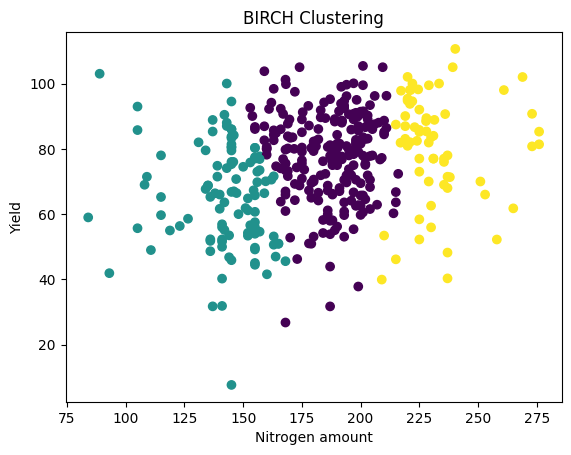

In [15]:
from sklearn.cluster import Birch

# Define the BIRCH model
birch_model = Birch(n_clusters=3)

# Fit the model to the data
birch_model.fit(X)

# Add the BIRCH cluster labels to the dataframe
df['birch_cluster'] = birch_model.labels_

# Print the cluster centers
print("BIRCH Cluster Centers:\n", birch_model.subcluster_centers_)

# Plot the clusters
plt.scatter(df['real_n_amount_kg_n_ha'], df['real_yield_dt_ha'], c=df['birch_cluster'], cmap='viridis')
plt.xlabel("Nitrogen amount")
plt.ylabel("Yield")
plt.title("BIRCH Clustering")
plt.show()

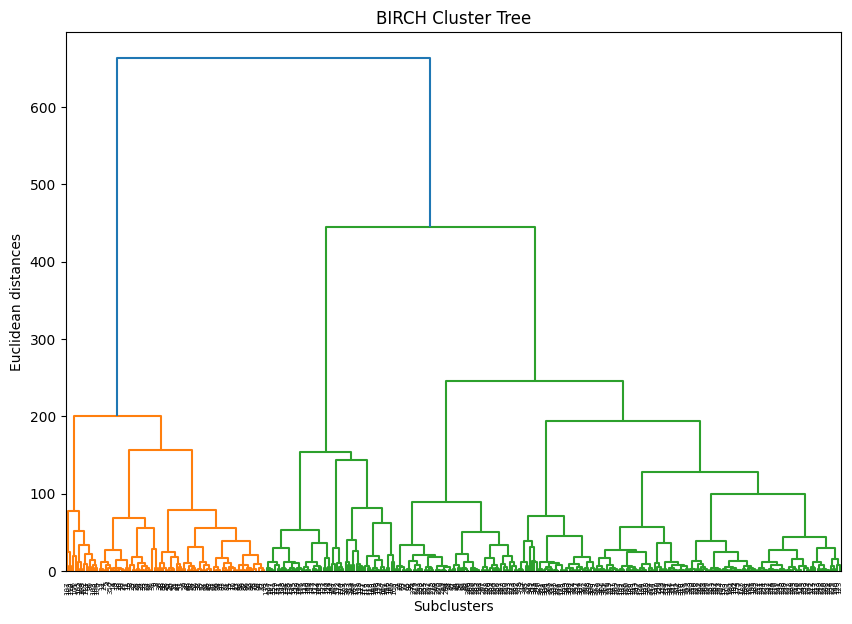

In [16]:
from sklearn.cluster import Birch

import scipy.cluster.hierarchy as sch

# Define the BIRCH model
birch_model = Birch(n_clusters=3)

# Fit the model to the data
birch_model.fit(X)

# Extract the subcluster centers
subcluster_centers = birch_model.subcluster_centers_

# Perform hierarchical clustering on the subcluster centers
linked = sch.linkage(subcluster_centers, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(linked)
plt.title("BIRCH Cluster Tree")
plt.xlabel("Subclusters")
plt.ylabel("Euclidean distances")
plt.show()

DBSCAN Clusters: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(-1)}


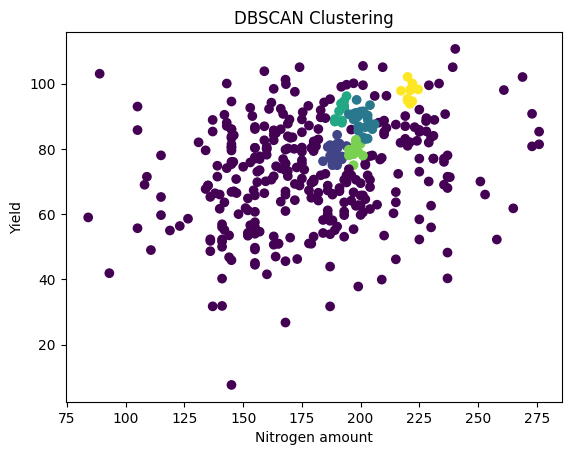

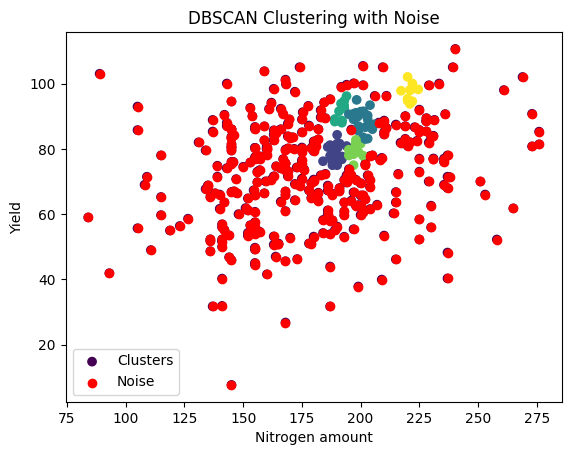

In [17]:
from sklearn.cluster import DBSCAN

# Define the DBSCAN model
dbscan = DBSCAN(eps=5, min_samples=10, metric='manhattan')  # max distance and minimum neighbors with Manhattan distance

# Fit the model to the data
dbscan.fit(X)

# Add the DBSCAN cluster labels to the dataframe
df['dbscan_cluster'] = dbscan.labels_

# Print the unique clusters
print("DBSCAN Clusters:", set(dbscan.labels_))

# Plot the clusters
plt.scatter(df['real_n_amount_kg_n_ha'], df['real_yield_dt_ha'], c=df['dbscan_cluster'], cmap='viridis')
plt.xlabel("Nitrogen amount")
plt.ylabel("Yield")
plt.title("DBSCAN Clustering")
plt.show()
# Mark the noise points
noise = df[df['dbscan_cluster'] == -1]

# Plot the clusters with noise marked
plt.scatter(df['real_n_amount_kg_n_ha'], df['real_yield_dt_ha'], c=df['dbscan_cluster'], cmap='viridis', label='Clusters')
plt.scatter(noise['real_n_amount_kg_n_ha'], noise['real_yield_dt_ha'], color='red', label='Noise')
plt.xlabel("Nitrogen amount")
plt.ylabel("Yield")
plt.title("DBSCAN Clustering with Noise")
plt.legend()
plt.show()

Fuzzy C-Means Cluster Centers:
 [[196.46195334  85.81289731]
 [158.000172    79.78603717]
 [189.4407071   64.86995883]
 [140.23118595  58.84563072]
 [230.40400355  82.18966026]]


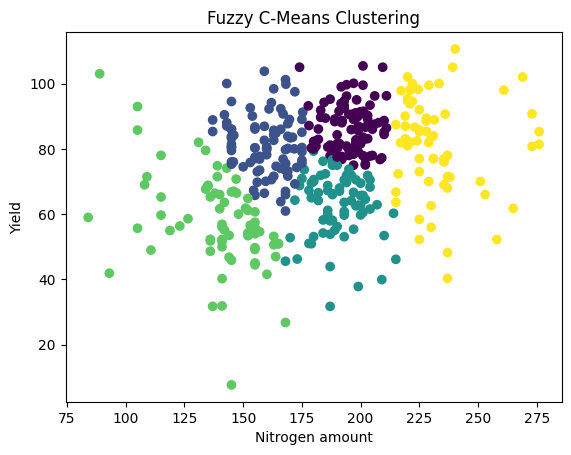

In [18]:
import skfuzzy as fuzz

# Define the number of clusters
n_clusters = 5

# Apply Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X.T, n_clusters, 2, error=0.005, maxiter=10000, init=None
)

# Assign the cluster labels to the dataframe
cluster_labels = np.argmax(u, axis=0)
df['fuzzy_cluster'] = cluster_labels

# Print the cluster centers
print("Fuzzy C-Means Cluster Centers:\n", cntr)

# Plot the clusters
plt.scatter(df['real_n_amount_kg_n_ha'], df['real_yield_dt_ha'], c=df['fuzzy_cluster'], cmap='viridis')
plt.xlabel("Nitrogen amount")
plt.ylabel("Yield")
plt.title("Fuzzy C-Means Clustering")
plt.show()

Affinity Propagation Clusters: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20)}


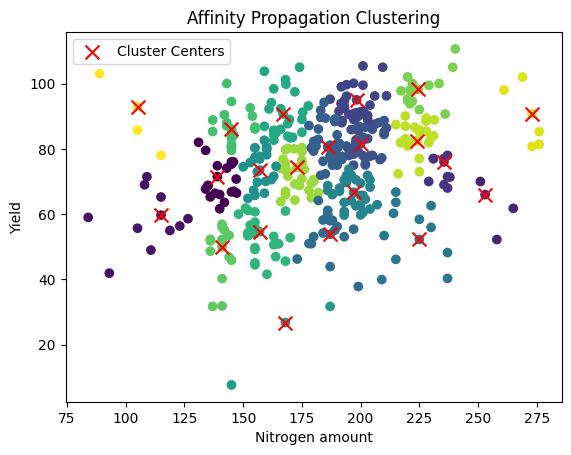

In [19]:
from sklearn.cluster import AffinityPropagation

# Define the Affinity Propagation model
affinity_propagation = AffinityPropagation(random_state=42, 
                                           damping=0.5, 
                                           # preference=-500
                                           )

# Fit the model to the data
X = df[["real_n_amount_kg_n_ha", "real_yield_dt_ha"]].values
affinity_propagation.fit(X)


# Add the Affinity Propagation cluster labels to the dataframe
df['affinity_cluster'] = affinity_propagation.labels_

# Print the unique clusters
print("Affinity Propagation Clusters:", set(affinity_propagation.labels_))

# Plot the clusters
plt.scatter(df['real_n_amount_kg_n_ha'], df['real_yield_dt_ha'], c=df['affinity_cluster'], cmap='viridis')
# Scatter the cluster centers
cluster_centers = affinity_propagation.cluster_centers_
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=100, label='Cluster Centers')
plt.legend()
plt.xlabel("Nitrogen amount")
plt.ylabel("Yield")
plt.title("Affinity Propagation Clustering")
plt.show()

# Disponibility and responsibility